In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors


In [3]:
!unzip /content/new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [1]:
!pip install -U tensorflow
!pip install -U keras
!pip install -U tensorflow_addons
!pip install -U efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Data generators for separate train/validation folders
def create_data_generators(train_dir, valid_dir, img_size=(256,256), batch_size=16):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    valid_gen = datagen.flow_from_directory(
        valid_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, valid_gen

# Build model
def build_model(input_shape=(256,256,3), num_classes=28, lr=1e-4):
    base = EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base.layers:
        layer.trainable = False
    # fine-tune top layers
    for layer in base.layers[-30:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(base.input, outputs)
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Callbacks
def get_callbacks(filepath='best_model.h5'):
    return [
        ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    ]

# Training
def train(train_dir, valid_dir, img_size=(256,256), batch_size=16, epochs=10):
    train_gen, valid_gen = create_data_generators(train_dir, valid_dir, img_size, batch_size)
    num_classes = len(train_gen.class_indices)
    model = build_model(input_shape=(*img_size,3), num_classes=num_classes)
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        callbacks=get_callbacks()
    )
    model.save('final_model.h5')
    return model, history, train_gen.class_indices

if __name__ == '__main__':
    TRAIN_DIR = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
    VALID_DIR = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
    model, history, classes = train(TRAIN_DIR, VALID_DIR)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6952 - loss: 1.1476
Epoch 1: val_accuracy improved from -inf to 0.98088, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 377s 75ms/step - accuracy: 0.6952 - loss: 1.1475 - val_accuracy: 0.9809 - val_loss: 0.0596 - learning_rate: 1.0000e-04
Epoch 2/10
4393/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9518 - loss: 0.1501
Epoch 2: val_accuracy improved from 0.98088 to 0.98822, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 319s 67ms/step - accuracy: 0.9518 - loss: 0.1501 - val_accuracy: 0.9882 - val_loss: 0.0347 - learning_rate: 1.0000e-04
Epoch 3/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9711 - loss: 0.0872
Epoch 3: val_accuracy improved from 0.98822 to 0.99072, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 292s 66ms/step - accuracy: 0.9711 - loss: 0.0872 - val_accuracy: 0.9907 - val_loss: 0.0293 - learning_rate: 1.0000e-04
Epoch 4/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9775 - loss: 0.0691
Epoch 4: val_accuracy improved from 0.99072 to 0.99277, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 292s 66ms/step - accuracy: 0.9775 - loss: 0.0691 - val_accuracy: 0.9928 - val_loss: 0.0229 - learning_rate: 1.0000e-04
Epoch 5/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9824 - loss: 0.0543
Epoch 5: val_accuracy improved from 0.99277 to 0.99402, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 292s 66ms/step - accuracy: 0.9824 - loss: 0.0543 - val_accuracy: 0.9940 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 6/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9861 - loss: 0.0415
Epoch 6: val_accuracy improved from 0.99402 to 0.99442, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 292s 67ms/step - accuracy: 0.9861 - loss: 0.0415 - val_accuracy: 0.9944 - val_loss: 0.0164 - learning_rate: 1.0000e-04
Epoch 7/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9897 - loss: 0.0329
Epoch 7: val_accuracy improved from 0.99442 to 0.99459, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 293s 67ms/step - accuracy: 0.9897 - loss: 0.0329 - val_accuracy: 0.9946 - val_loss: 0.0176 - learning_rate: 1.0000e-04
Epoch 8/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9894 - loss: 0.0327
Epoch 8: val_accuracy improved from 0.99459 to 0.99528, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 326s 74ms/step - accuracy: 0.9894 - loss: 0.0327 - val_accuracy: 0.9953 - val_loss: 0.0162 - learning_rate: 1.0000e-04
Epoch 9/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9901 - loss: 0.0289
Epoch 9: val_accuracy improved from 0.99528 to 0.99533, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 294s 67ms/step - accuracy: 0.9901 - loss: 0.0289 - val_accuracy: 0.9953 - val_loss: 0.0147 - learning_rate: 1.0000e-04
Epoch 10/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9915 - loss: 0.0262
Epoch 10: val_accuracy improved from 0.99533 to 0.99579, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 294s 67ms/step - accuracy: 0.9915 - loss: 0.0262 - val_accuracy: 0.9958 - val_loss: 0.0133 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


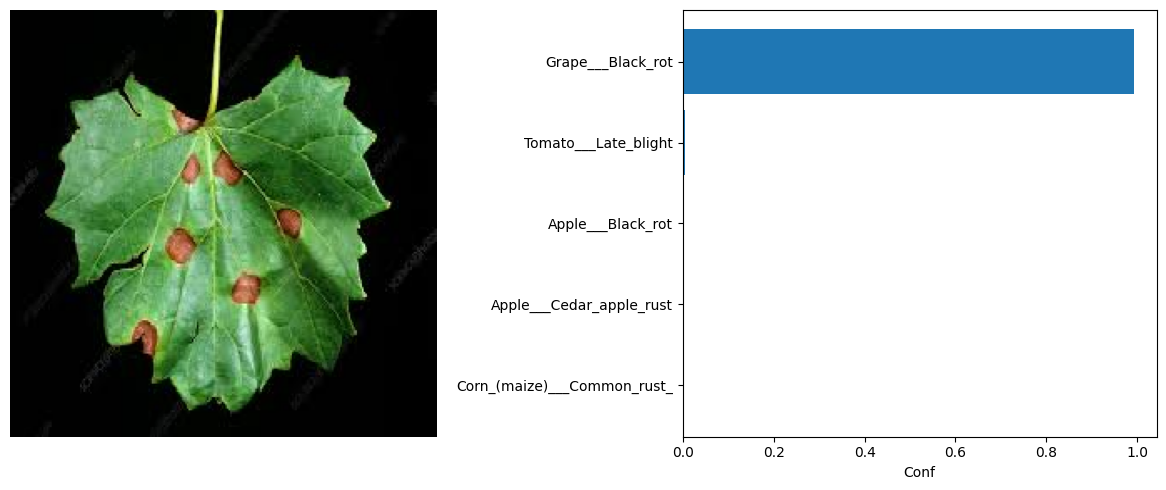

{'disease': 'Grape___Black_rot', 'conf': 0.9932646751403809, 'top': [('Grape___Black_rot', 0.9932646751403809), ('Tomato___Late_blight', 0.004608962219208479), ('Apple___Black_rot', 0.0008354316814802587), ('Apple___Cedar_apple_rust', 0.0006480852607637644), ('Corn_(maize)___Common_rust_', 0.0006208980921655893)]}


In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

class LeafDiseaseChecker:
    def __init__(self, model_path, idx_path=None, auto_dir=None):
        self.model = load_model(model_path)
        # Load or auto-generate class indices
        if idx_path and os.path.exists(idx_path):
            mapping = json.load(open(idx_path))
        elif auto_dir:
            mapping = self._make_indices(auto_dir)
            json.dump(mapping, open(idx_path or 'class_indices.json','w'))
        else:
            mapping = {}
        self.idx_to_class = {v:k for k,v in mapping.items()}

    def _make_indices(self, data_dir):
        classes = sorted([d for d in os.listdir(data_dir)
                          if os.path.isdir(os.path.join(data_dir,d))])
        return {c:i for i,c in enumerate(classes)}

    def predict(self, img_path, size=(256,256), top_k=5, viz=True):
        if not os.path.exists(img_path): return {'error':'file not found'}
        img = load_img(img_path, target_size=size)
        arr = preprocess_input(np.expand_dims(img_to_array(img),0))
        preds = self.model.predict(arr)[0]
        idx = np.argmax(preds)
        lab = self.idx_to_class.get(idx, idx)
        top = sorted(enumerate(preds), key=lambda x:-x[1])[:top_k]
        result = {'disease':lab, 'conf':float(preds[idx]),
                  'top':[(self.idx_to_class.get(i,i),float(p)) for i,p in top]}
        if viz: self._viz(img, top)
        return result

    def _viz(self, img, top):
        fig, axes = plt.subplots(1,2,figsize=(12,5))
        axes[0].imshow(img); axes[0].axis('off')
        classes, vals = zip(*[(self.idx_to_class.get(i,i),p) for i,p in top])
        axes[1].barh(classes, vals); axes[1].invert_yaxis(); axes[1].set_xlabel('Conf')
        plt.tight_layout(); plt.show()

    def batch(self, d, size=(256,256)):
        res={}
        for f in os.listdir(d):
            if f.lower().endswith(('.jpg','.png','.jpeg')):
                res[f]=self.predict(os.path.join(d,f), size, viz=False)
        summary = {v['disease']:sum(1 for r in res.values() if r.get('disease')==v['disease'])
                   for v in res.values()}
        print({'total':len(res), 'summary':summary})
        return res

if __name__=='__main__':
    chk = LeafDiseaseChecker('/content/best_model.h5', idx_path='class_indices.json',
                              auto_dir='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')
    print(chk.predict('/content/download.jpg'))
    # chk.batch('test_folder')
